In [153]:
import pandas as pd
import time
import datetime
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit

In [154]:
df = pd.read_csv("training_set_VU_DM.csv")
#df = pd.read_csv("sample_training_set.csv")

# Get a sample from the training dataset
#df = df.sample(n=500000)
#df_test.to_csv('sample_training_set.csv')

df_test = pd.read_csv("test_set_VU_DM.csv")

## Notes
- There are multiple search results for the same search id
- No. unique id's in the full training set is 199795, 175188 in the sample set
- Position, click_bool , booking_bool and gross_booking_usd is not included in test set! 

## Descriptive dataframe

In [118]:
#df_user = df[['srch_id', 'date_time', 'site_id', 'visitor_location_country_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd']]

In [119]:
# Make a descriptive dataframe
df_descr = pd.concat([df.nunique(), df.isna().sum(), df.notna().sum(), df.dtypes, df.max(), df.min()], axis=1)
df_descr.columns = ['Unique values', 'NaN count', 'non NaN count', 'Datatype', 'Max value', 'Min value']
df_descr

,Unique values,NaN count,non NaN count,Datatype,Max value,Min value
srch_id,10045,0,250000,int64,16741,1
date_time,10040,0,250000,object,2013-06-30 23:11:41,2012-11-01 00:45:48
site_id,31,0,250000,int64,34,1
visitor_location_country_id,123,0,250000,int64,230,2
visitor_hist_starrating,179,236657,13343,float64,5.0,1.67
visitor_hist_adr_usd,557,236629,13371,float64,920.06,31.54
prop_country_id,125,0,250000,int64,230,2
prop_id,63563,0,250000,int64,140820,1
prop_starrating,6,0,250000,int64,5,0
prop_review_score,10,344,249656,float64,5.0,0.0


## Split numeric and categoric variables roughly , plot them

In [120]:
descr2 = df_descr[df_descr['Unique values'] <= 10].index.tolist() # (almost) all are categorical variables
descr3 = df_descr[df_descr['Unique values'] > 50].index.tolist() # (almost) all are numerical variables


#df[descr2].hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8)
descr3.remove('date_time')
descr3.remove('srch_id')
#df.boxplot(column=descr3, figsize=(16, 20))



array([[<AxesSubplot:title={'center':'prop_starrating'}>,
        <AxesSubplot:title={'center':'prop_review_score'}>,
        <AxesSubplot:title={'center':'prop_brand_bool'}>,
        <AxesSubplot:title={'center':'promotion_flag'}>,
        <AxesSubplot:title={'center':'srch_adults_count'}>],
       [<AxesSubplot:title={'center':'srch_children_count'}>,
        <AxesSubplot:title={'center':'srch_room_count'}>,
        <AxesSubplot:title={'center':'srch_saturday_night_bool'}>,
        <AxesSubplot:title={'center':'random_bool'}>,
        <AxesSubplot:title={'center':'comp1_rate'}>],
       [<AxesSubplot:title={'center':'comp1_inv'}>,
        <AxesSubplot:title={'center':'comp2_rate'}>,
        <AxesSubplot:title={'center':'comp2_inv'}>,
        <AxesSubplot:title={'center':'comp3_rate'}>,
        <AxesSubplot:title={'center':'comp3_inv'}>],
       [<AxesSubplot:title={'center':'comp4_rate'}>,
        <AxesSubplot:title={'center':'comp4_inv'}>,
        <AxesSubplot:title={'center':'comp5

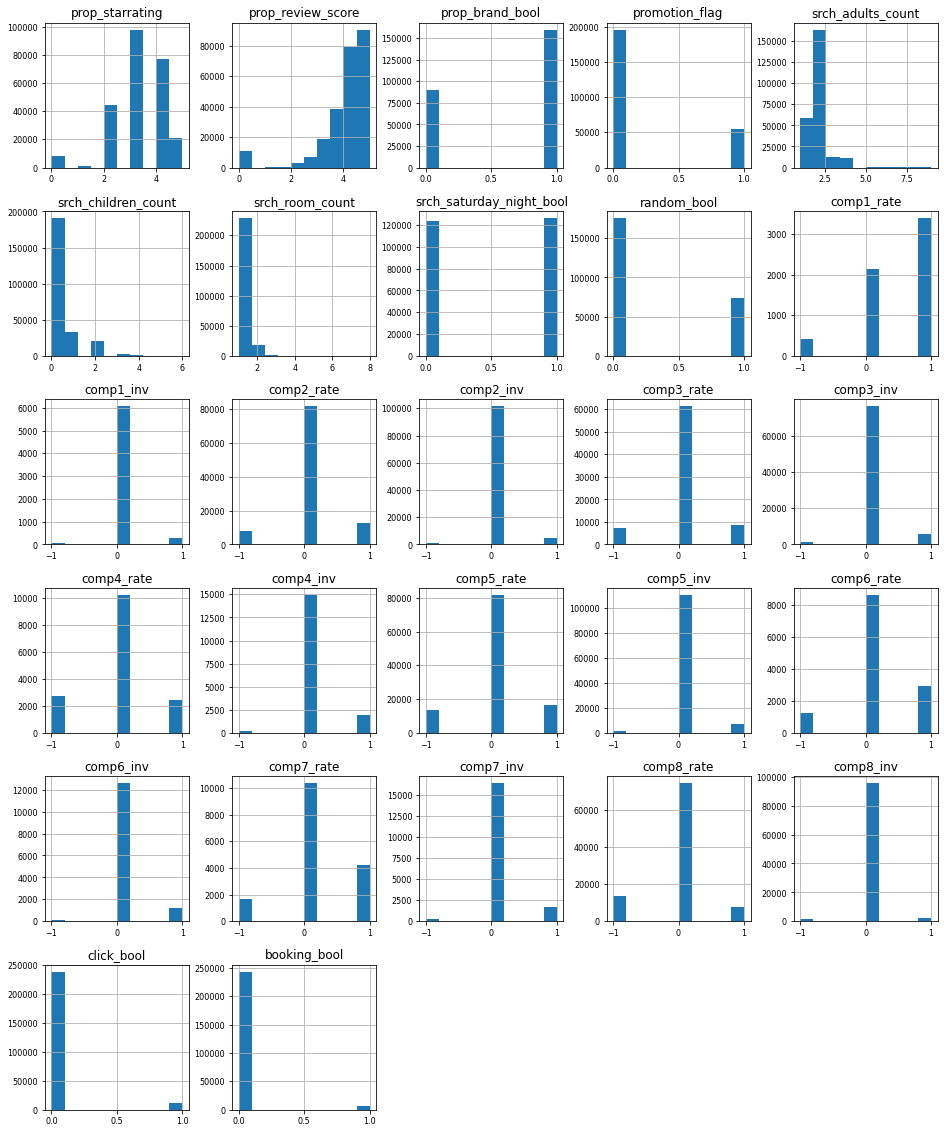

In [121]:
df[descr2].hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8)

<AxesSubplot:xlabel='date'>

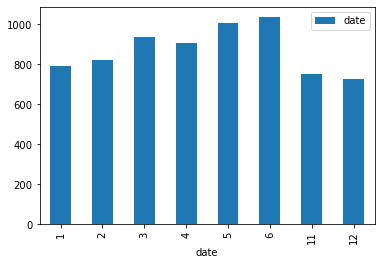

In [122]:
## Check if there is some relation between date time and booking

#split date time in date and time
df[['date', 'time']] = df['date_time'].str.split(' ', 1, expand=True)
df['date'] = pd.to_datetime(df['date'])

# Show booked items and in which month they occurred
df_only_booked = df[df['booking_bool']==1]
df_only_booked = df_only_booked[['date']]
df_only_booked.groupby(df_only_booked["date"].dt.month).count().plot(kind="bar", stacked=True)


<AxesSubplot:>

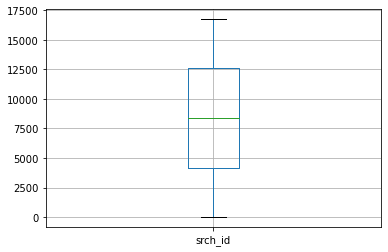

In [123]:
df.boxplot(column = 'srch_id')

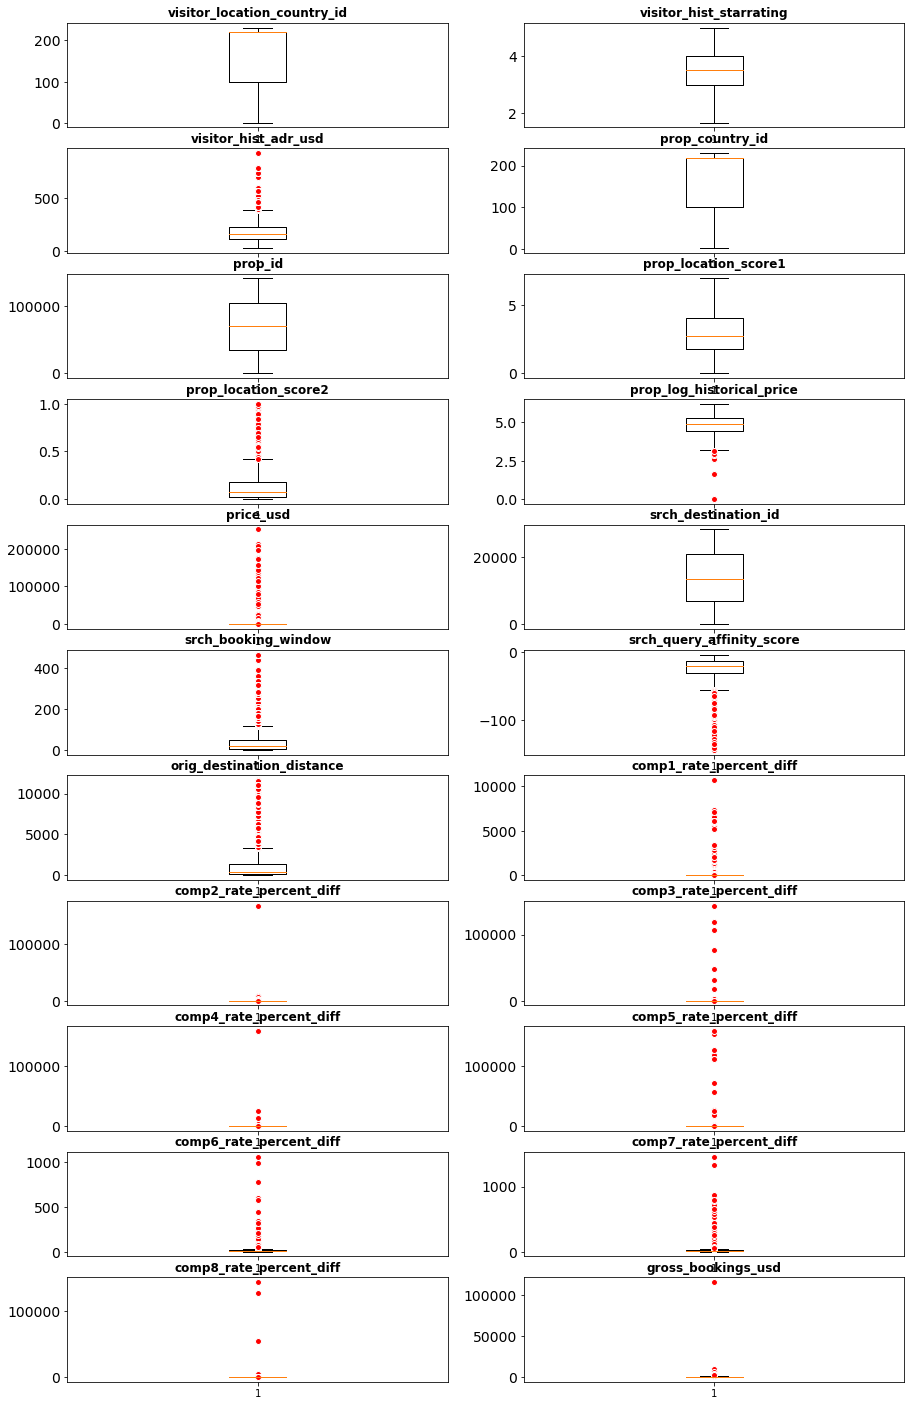

In [124]:
df_numerical = df[descr3]

red_circle = dict(markerfacecolor = 'red', marker = 'o', markeredgecolor = 'white')

fig, axs = plt.subplots(11, 2, figsize=(15,25))

for i, ax in enumerate(axs.flat):
    ax.boxplot(df_numerical.iloc[:,i].dropna(), flierprops = red_circle)
    ax.set_title(df_numerical.columns[i], fontweight = 'bold')
    ax.tick_params(axis = 'y', labelsize = 14)

plt.show()

# To do - ?
- Count the amount of clicks per property and plot
- Fill in missing values (are a lot)
- Identify multiple searches of 1 user on 1 property?
- Explore if further data transformation is necessary - how to deal with sparse data
- For modelling: group by user and make ranking

In [125]:
# Show top 5 occuring properties
df2 = df.groupby('prop_id').count()
df2 = df2.sort_values(['srch_id'],ascending=False).head()
print(df2['srch_id'])

# Show top 5 booked properties
df_top5_prop = df.groupby('prop_id').agg({'booking_bool': sum})
df_top5_prop = df_top5_prop.sort_values(['booking_bool'],ascending=False).head()
df_top5_prop

prop_id
124342    138
104517    137
137997    134
59781     132
40279     131
Name: srch_id, dtype: int64


,booking_bool
prop_id,
137997,10
104517,9
53494,8
116942,8
61529,8


<ipython-input-126-7538a5879ba8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['booking_bool'] = df['booking_bool'].values


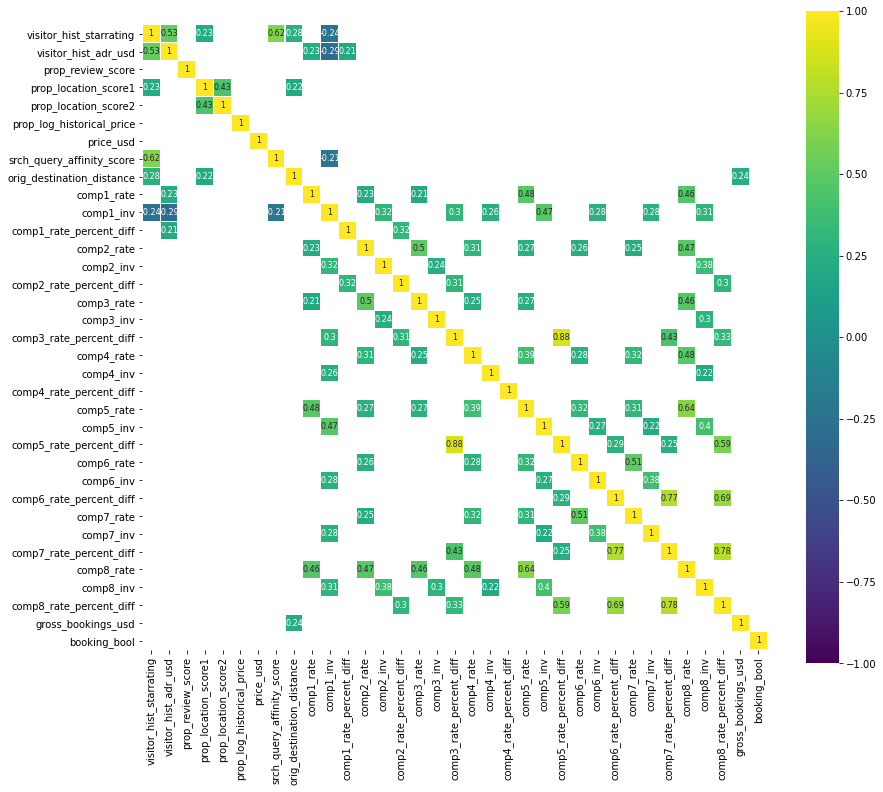

In [126]:
# Plot correlation matrix of all float values + booking or not
df_num = df.select_dtypes(include=[float])
df_num['booking_bool'] = df['booking_bool'].values
corr = df_num.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr[(corr >= 0.2) | (corr <= -0.2)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);


https://towardsdatascience.com/learning-to-rank-with-python-scikit-learn-327a5cfd81f

In [127]:
#df = pd.read_csv("test_set_VU_DM.csv")
#df

## Tried naive bayes , didnt really work, but did get result format
#### See https://medium.com/predictly-on-tech/learning-to-rank-using-xgboost-83de0166229d

In [173]:
from sklearn.cluster import KMeans

X_train = df.loc[:, df.columns.isin(['prop_starrating', 'prop_brand_bool', 'prop_location_score1',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
       'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool',
       'random_bool'])]
y_train = df.loc[:, df.columns.isin(['booking_bool'])]

X_test = df_test.loc[:, df_test.columns.isin(['prop_starrating', 'prop_brand_bool', 'prop_location_score1',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
       'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool',
       'random_bool'])]
y_test = df_test.loc[:, df_test.columns.isin(['booking_bool'])]

km = KMeans(n_clusters = 15)
kmean=km.fit(X_train)

X_dist = kmean.transform(X_train)**2
print(X_dist)
y_kmeans = km.predict(X_train)
df['cluster_predict'] = y_kmeans
df['cluster_distance'] = X_dist.sum(axis=1).round(2)

[[4.33399362e+03 9.56278077e+12 1.39662908e+14 ... 2.60159391e+13
  8.17143938e+09 4.45416843e+11]
 [1.55497952e+03 9.56237276e+12 1.39661348e+14 ... 2.60152661e+13
  8.15951689e+09 4.45328791e+11]
 [1.85214689e+03 9.56231673e+12 1.39661134e+14 ... 2.60151737e+13
  8.15788019e+09 4.45316699e+11]
 ...
 [3.87610053e+03 9.56281645e+12 1.39663044e+14 ... 2.60159979e+13
  8.17248183e+09 4.45424544e+11]
 [6.87667070e+02 9.56256906e+12 1.39662099e+14 ... 2.60155899e+13
  8.16525128e+09 4.45371153e+11]
 [9.86693613e+03 9.56305147e+12 1.39663942e+14 ... 2.60163856e+13
  8.17935380e+09 4.45475268e+11]]


,srch_id,prop_id,cluster_predict,cluster_distance,booking_bool
4958346,332785,134949,0,6.832418e+14,0
4958343,332785,88083,0,6.832383e+14,0
4958344,332785,94508,0,6.832371e+14,0
4958341,332785,55110,0,6.832359e+14,0
4958342,332785,77700,0,6.832348e+14,0
...,...,...,...,...,...
19,1,89073,0,6.832257e+14,0
5,1,30184,0,6.832252e+14,0
13,1,74474,0,6.832233e+14,0
9,1,56880,0,6.832147e+14,0


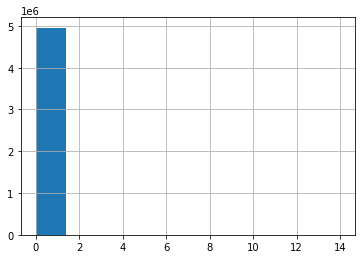

In [174]:
df_train_result = df[['srch_id', 'prop_id', 'cluster_predict', 'cluster_distance', 'booking_bool']]
df_train_result['cluster_predict'].hist()

df_clust = df_train_result.sort_values(["srch_id", "cluster_distance"], ascending=False)
df_clust

In [175]:
km.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [158]:
from sklearn.naive_bayes import MultinomialNB
pd.options.mode.chained_assignment = None  # default='warn'

clf = MultinomialNB()
clf.fit(X_train, y_train.values.ravel())
NB_result = clf.predict(X_train)
score = clf.score(X_train, y_train, sample_weight=None)
NB_prob = clf.predict_proba(X_train)

print('Accuracy Training: ', score)
print(clf.classes_)
print(NB_prob[:,1]) # Probabilities of being booked
df_train_result = df[['srch_id', 'prop_id', 'booking_bool']]
df_train_result['booking_pred'] = NB_result
df_train_result['booking_pred_prob'] = NB_prob[:,1]
df_sorted = df_train_result.sort_values(["srch_id", "booking_pred_prob"], ascending=[True, False])
df_sorted[['srch_id', 'prop_id']]

Accuracy Training:  0.8664550907792455
[0 1]
[0.06918335 0.29176339 0.33185999 ... 0.0079927  0.02143285 0.00307976]


,srch_id,prop_id
3,1,27348
9,1,56880
13,1,74474
5,1,30184
19,1,89073
...,...,...
4958342,332785,77700
4958341,332785,55110
4958344,332785,94508
4958343,332785,88083


In [172]:
## Now for test csv

NB_prob_t = clf.predict_proba(X_test)
#print(NB_prob_t[:,1]) # Probabilities of being booked

df_test_result = df_test[['srch_id', 'prop_id']]
df_test_result['booking_pred_prob'] = NB_prob_t[:,1]
df_sorted = df_test_result.sort_values(["srch_id", "booking_pred_prob"], ascending=[True, False])
final_frame = df_sorted[['srch_id', 'prop_id']]
#final_frame
# header "SearchId ,PropertyId" 
np.savetxt(r'group93.txt', final_frame.values , fmt='%d')
final_frame.to_csv('group93.csv', index=False)
final_frame

AttributeError: 'NoneType' object has no attribute 'to_csv'